In [1]:
#Installing Package

#install.packages("dplyr")
#install.packages("data.table")
#install.packages("ggplot2")
#install.packages("caret")
#install.packages("corrplot")
#install.packages("xgboost")
#install.packages("cowplot")
#install.packages("glmnet")
#install.packages("ranger")

In [2]:
#Loading Packages

library(data.table) # used for reading and manipulation of data
library(dplyr)      # used for data manipulation and joining
library(ggplot2)    # used for ploting 
library(caret)      # used for modeling
library(corrplot)   # used for making correlation plot
library(xgboost)    # used for building XGBoost model
library(cowplot)    # used for combining multiple plots


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: lattice

corrplot 0.92 loaded


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [3]:
train = fread("C:/Users/rahul/Downloads/r/train_v9rqX0R.csv")
test = fread("C:/Users/rahul/Downloads/r/test_AbJTz2l.csv")
submission = fread("C:/Users/rahul/Downloads/r/sample_submission_8RXa3c6.csv")

In [4]:
dim(train)
dim(test)

[1] 8523   12

[1] 5681   11

In [5]:
names(train)

[1] "Item_Identifier"           "Item_Weight"              
 [3] "Item_Fat_Content"          "Item_Visibility"          
 [5] "Item_Type"                 "Item_MRP"                 
 [7] "Outlet_Identifier"         "Outlet_Establishment_Year"
 [9] "Outlet_Size"               "Outlet_Location_Type"     
[11] "Outlet_Type"               "Item_Outlet_Sales"

In [6]:
names(test)

[1] "Item_Identifier"           "Item_Weight"              
 [3] "Item_Fat_Content"          "Item_Visibility"          
 [5] "Item_Type"                 "Item_MRP"                 
 [7] "Outlet_Identifier"         "Outlet_Establishment_Year"
 [9] "Outlet_Size"               "Outlet_Location_Type"     
[11] "Outlet_Type"

In [7]:
str(train)

Classes 'data.table' and 'data.frame':	8523 obs. of  12 variables:
 $ Item_Identifier          : chr  "FDA15" "DRC01" "FDN15" "FDX07" ...
 $ Item_Weight              : num  9.3 5.92 17.5 19.2 8.93 ...
 $ Item_Fat_Content         : chr  "Low Fat" "Regular" "Low Fat" "Regular" ...
 $ Item_Visibility          : num  0.016 0.0193 0.0168 0 0 ...
 $ Item_Type                : chr  "Dairy" "Soft Drinks" "Meat" "Fruits and Vegetables" ...
 $ Item_MRP                 : num  249.8 48.3 141.6 182.1 53.9 ...
 $ Outlet_Identifier        : chr  "OUT049" "OUT018" "OUT049" "OUT010" ...
 $ Outlet_Establishment_Year: int  1999 2009 1999 1998 1987 2009 1987 1985 2002 2007 ...
 $ Outlet_Size              : chr  "Medium" "Medium" "Medium" "" ...
 $ Outlet_Location_Type     : chr  "Tier 1" "Tier 3" "Tier 1" "Tier 3" ...
 $ Outlet_Type              : chr  "Supermarket Type1" "Supermarket Type2" "Supermarket Type1" "Grocery Store" ...
 $ Item_Outlet_Sales        : num  3735 443 2097 732 995 ...
 - attr(*, ".i

In [8]:
str(test)

Classes 'data.table' and 'data.frame':	5681 obs. of  11 variables:
 $ Item_Identifier          : chr  "FDW58" "FDW14" "NCN55" "FDQ58" ...
 $ Item_Weight              : num  20.75 8.3 14.6 7.32 NA ...
 $ Item_Fat_Content         : chr  "Low Fat" "reg" "Low Fat" "Low Fat" ...
 $ Item_Visibility          : num  0.00756 0.03843 0.09957 0.01539 0.1186 ...
 $ Item_Type                : chr  "Snack Foods" "Dairy" "Others" "Snack Foods" ...
 $ Item_MRP                 : num  107.9 87.3 241.8 155 234.2 ...
 $ Outlet_Identifier        : chr  "OUT049" "OUT017" "OUT010" "OUT017" ...
 $ Outlet_Establishment_Year: int  1999 2007 1998 2007 1985 1997 2009 1985 2002 2007 ...
 $ Outlet_Size              : chr  "Medium" "" "" "" ...
 $ Outlet_Location_Type     : chr  "Tier 1" "Tier 2" "Tier 3" "Tier 2" ...
 $ Outlet_Type              : chr  "Supermarket Type1" "Supermarket Type1" "Grocery Store" "Supermarket Type1" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [9]:
test[,Item_Outlet_Sales := NA]
combi = rbind(train, test) # combining train and test datasets
dim(combi)

[1] 14204    12

In [10]:
options(repr.plot.width = 16, repr.plot.height = 8)
ggplot(train) + geom_histogram (aes (train$Item_Outlet_Sales), binwidth = 400, fill = "darkgreen") + xlab("Item_Outlet_Sales")

In [11]:
options(repr.plot.width = 16, repr.plot.height = 6)
p1 = ggplot(combi) + geom_histogram(aes(Item_Weight), binwidth = 0.5, fill = "blue")
p2 = ggplot(combi) + geom_histogram (aes (Item_Visibility), binwidth = 0.005, fill = "blue")
p3 = ggplot(combi) + geom_histogram(aes(Item_MRP), binwidth = 1, fill = "blue")
plot_grid(p1, p2, p3, nrow = 1) # plot_grid() from cowplot package

Warning message:
"Removed 2439 rows containing non-finite values (`stat_bin()`)."


In [12]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot(combi %>% group_by(Item_Fat_Content) %>% 
       summarise (Count = n())) + geom_bar(aes(Item_Fat_Content, Count), stat = "identity", fill = "coral1")

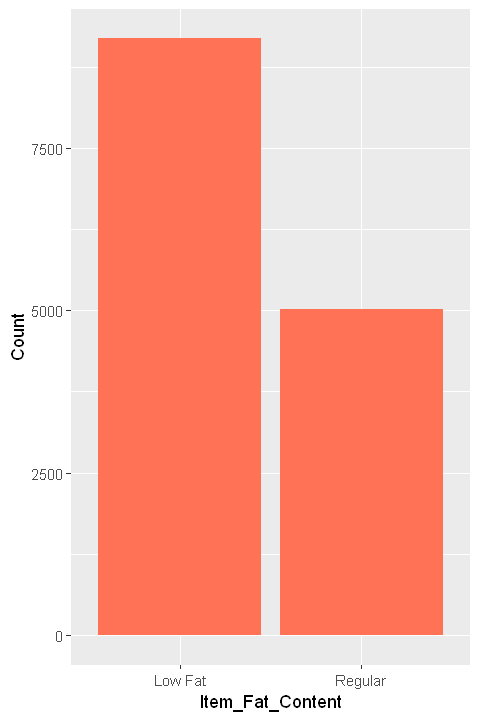

In [13]:
options(repr.plot.width = 4, repr.plot.height = 6)
combi$Item_Fat_Content[combi$Item_Fat_Content == "LF"] = "Low Fat"
combi$Item_Fat_Content[combi$Item_Fat_Content == "low fat"] = "Low Fat"
combi$Item_Fat_Content[combi$Item_Fat_Content == "reg"] = "Regular"
ggplot(combi %>% group_by(Item_Fat_Content) %>% summarise (Count = n())) +
geom_bar(aes(Item_Fat_Content, Count), stat = "identity", fill = "coral1")

In [14]:
options(repr.plot.width = 16, repr.plot.height = 10)

# plot for Item_Type 
p4 = ggplot(combi %>% group_by(Item_Type) %>% summarise (Count = n())) + 
  geom_bar(aes (Item_Type, Count), stat = "identity", fill = "coral1") + 
  xlab("") + 
  geom_label(aes (Item_Type, Count, label = Count), vjust = 0.5) + 
  theme (axis.text.x = element_text(angle = 45, hjust = 1)) + 
  ggtitle("Item_Type")

# plot for Outlet_Identifier 
p5 = ggplot(combi %>% group_by(Outlet_Identifier) %>% summarise (Count = n())) + 
  geom_bar(aes(Outlet_Identifier, Count), stat = "identity", fill = "coral1") + 
  geom_label(aes (Outlet_Identifier, Count, label = Count), vjust = 0.5) + 
  theme (axis.text.x = element_text(angle = 45, hjust = 1))

# plot for Outlet_Size 
p6 = ggplot(combi %>% group_by(Outlet_Size) %>% summarise(Count = n())) + 
  geom_bar(aes (Outlet_Size, Count), stat = "identity", fill = "coral1") + 
  geom_label(aes(Outlet_Size, Count, label = Count), vjust = 0.5) + 
  theme (axis.text.x = element_text(angle = 45, hjust = 1))

second_row = plot_grid(p5, p6, nrow = 1) 
plot_grid(p4, second_row, ncol = 1)

In [15]:
options(repr.plot.width = 16, repr.plot.height = 7)

# Plot for Outlet_Establishment_Year
p7 <- ggplot(combi %>% 
             group_by(Outlet_Establishment_Year) %>% 
             summarise(Count = n())) +
      geom_bar(aes(factor(Outlet_Establishment_Year), Count), 
               stat = "identity", 
               fill = "coral1") +
      geom_label(aes(factor(Outlet_Establishment_Year), Count, label = Count), 
                 vjust = 0.5) +
      xlab("Outlet_Establishment_Year") +
      theme(axis.text.x = element_text(size = 8.5))

# Plot for Outlet_Type
p8 <- ggplot(combi %>% 
             group_by(Outlet_Type) %>% 
             summarise(Count = n())) +
      geom_bar(aes(Outlet_Type, Count), 
               stat = "identity", 
               fill = "coral1") +
      geom_label(aes(factor(Outlet_Type), Count, label = Count), 
                 vjust = 0.5) + 
      theme(axis.text.x=element_text(size=8.5))

# Plotting both plots together
plot_grid(p7, p8, ncol=2)

In [16]:
options(repr.plot.width = 16, repr.plot.height = 10)

# Item_Weight vs Item_Outlet_Sales
p9 <- ggplot(train) +
      geom_point(aes(Item_Weight, Item_Outlet_Sales), colour = "violet", alpha = 0.3) +
      theme(axis.title = element_text(size = 8.5))

# Item_Visibility vs Item_Outlet_Sales
p10 <- ggplot(train) +
       geom_point(aes(Item_Visibility, Item_Outlet_Sales), colour = "violet", alpha = 0.3) +
       theme(axis.title = element_text(size = 8.5))

# Item_MRP vs Item_Outlet_Sales
p11 <- ggplot(train) +
       geom_point(aes(Item_MRP, Item_Outlet_Sales), colour = "violet", alpha = 0.3) +
       theme(axis.title = element_text(size = 8.5))

second_row_2 <- plot_grid(p10, p11, ncol=2)
plot_grid(p9, second_row_2, nrow=2)


Warning message:
"Removed 1463 rows containing missing values (`geom_point()`)."


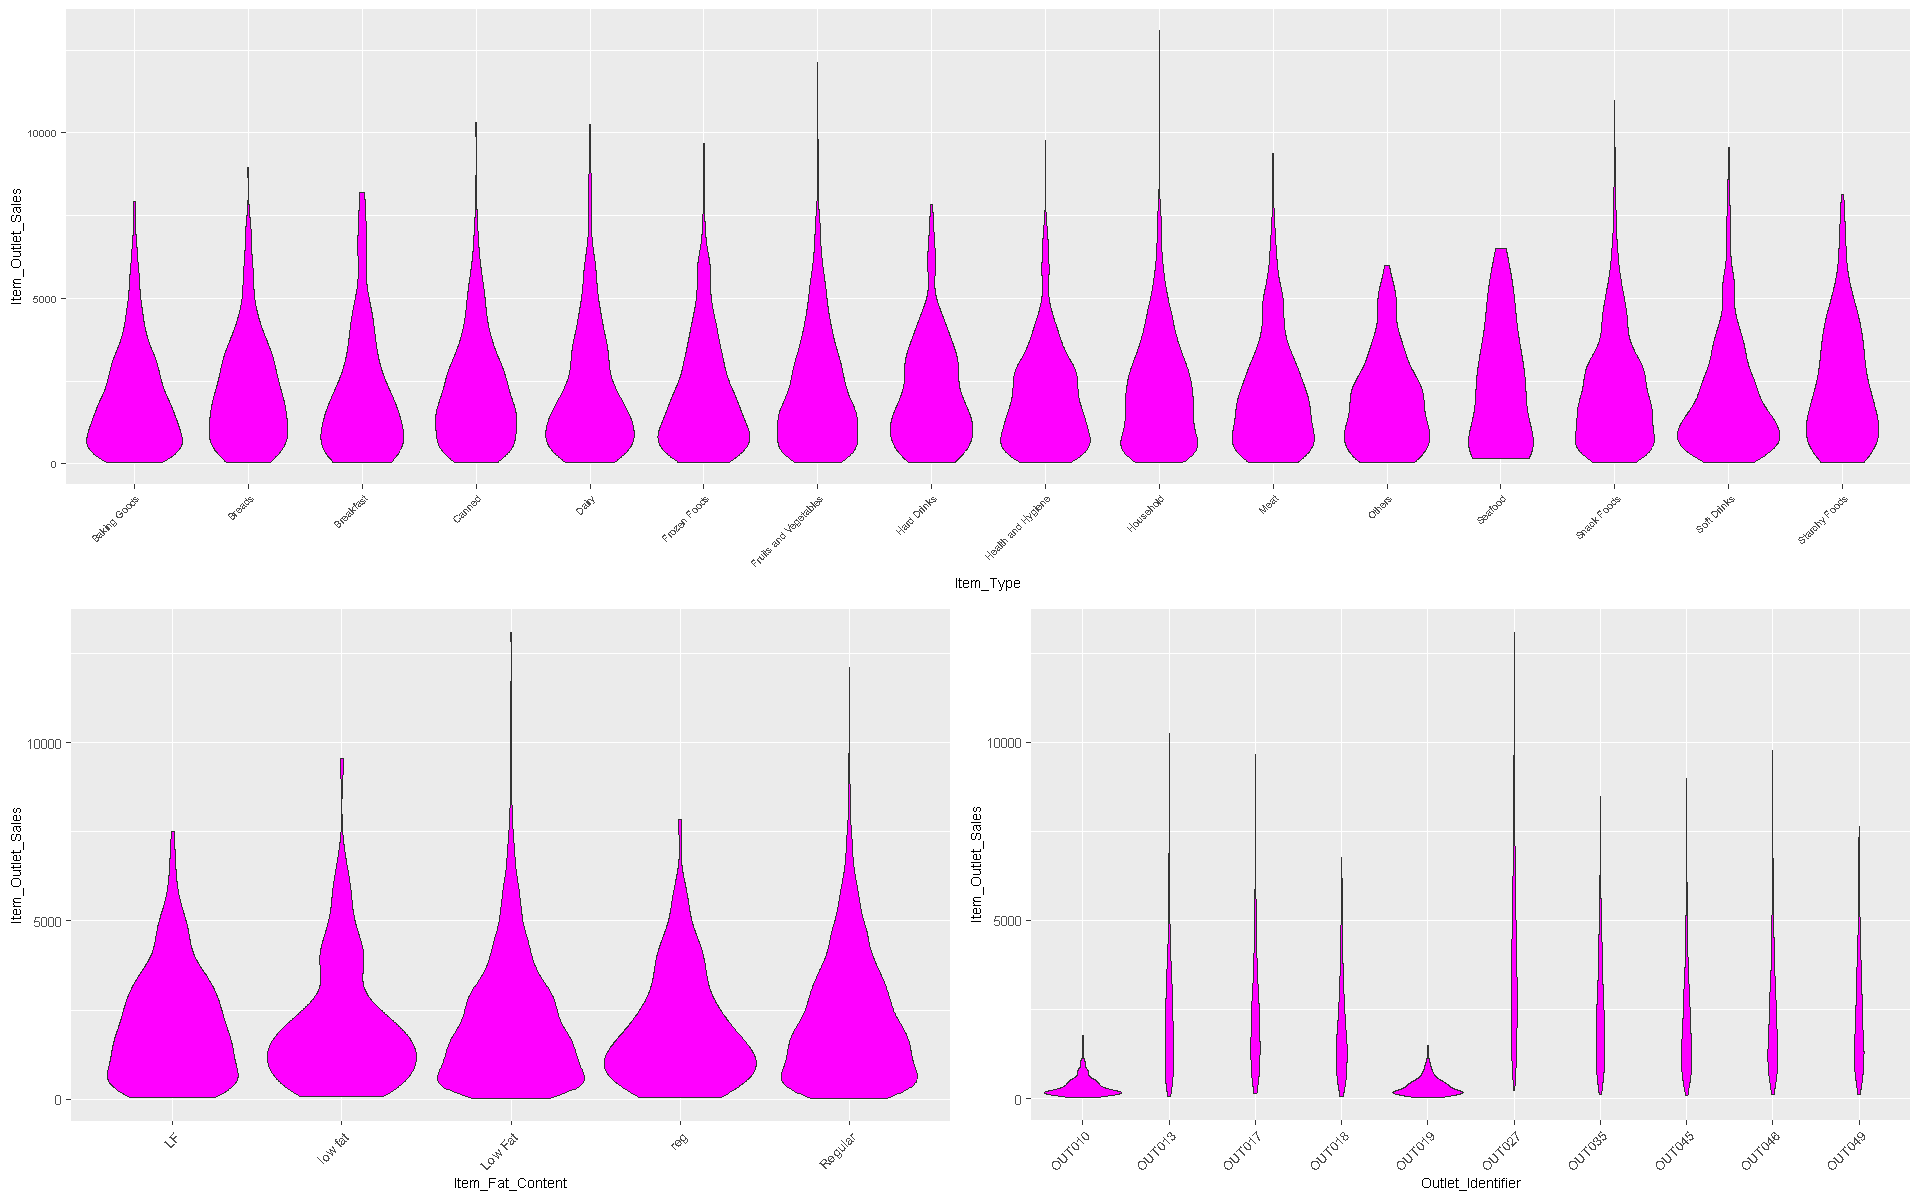

In [17]:
# Item_Type vs Item_Outlet_Sales 
p12 = ggplot(train) +
  geom_violin(aes(Item_Type, Item_Outlet_Sales), fill = "magenta") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 6), 
        axis.title = element_text(size = 8.5))

# Item_Fat_Content vs Item_Outlet_Sales 
p13 = ggplot(train) +
  geom_violin(aes(Item_Fat_Content, Item_Outlet_Sales), fill = "magenta") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text= element_text(size=8), 
        axis.title = element_text(size=8.5))

# Outlet_Identifier vs item Outlet Sales 
p14 = ggplot(train) +
  geom_violin(aes(Outlet_Identifier, Item_Outlet_Sales), fill = "magenta") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        axis.text = element_text(size = 8), 
        axis.title = element_text(size = 8.5))

second_row_3 = plot_grid(p13, p14, ncol = 2) 
plot_grid(p12, second_row_3, ncol = 1)

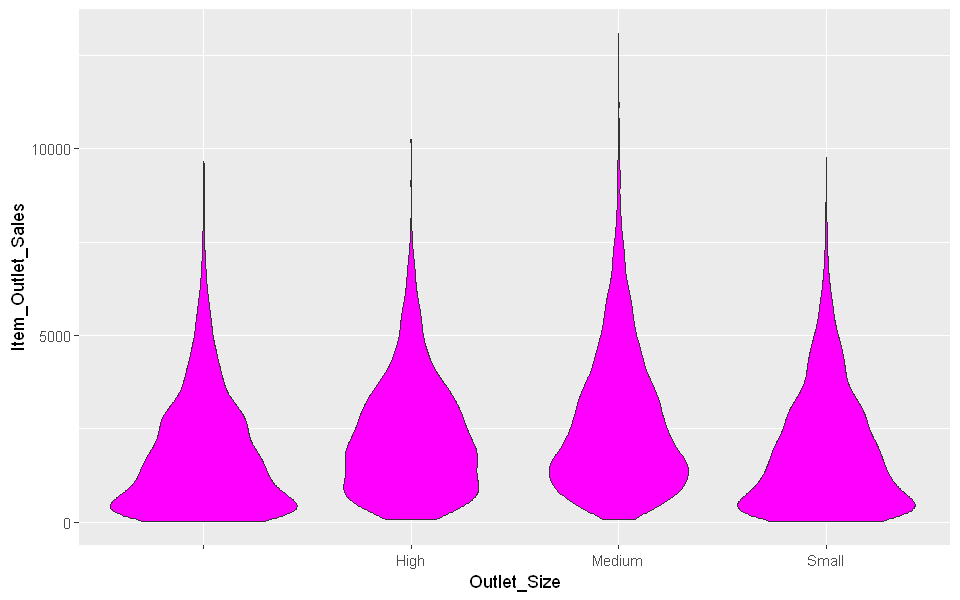

In [18]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(train) + geom_violin(aes(Outlet_Size, Item_Outlet_Sales), fill = "magenta")

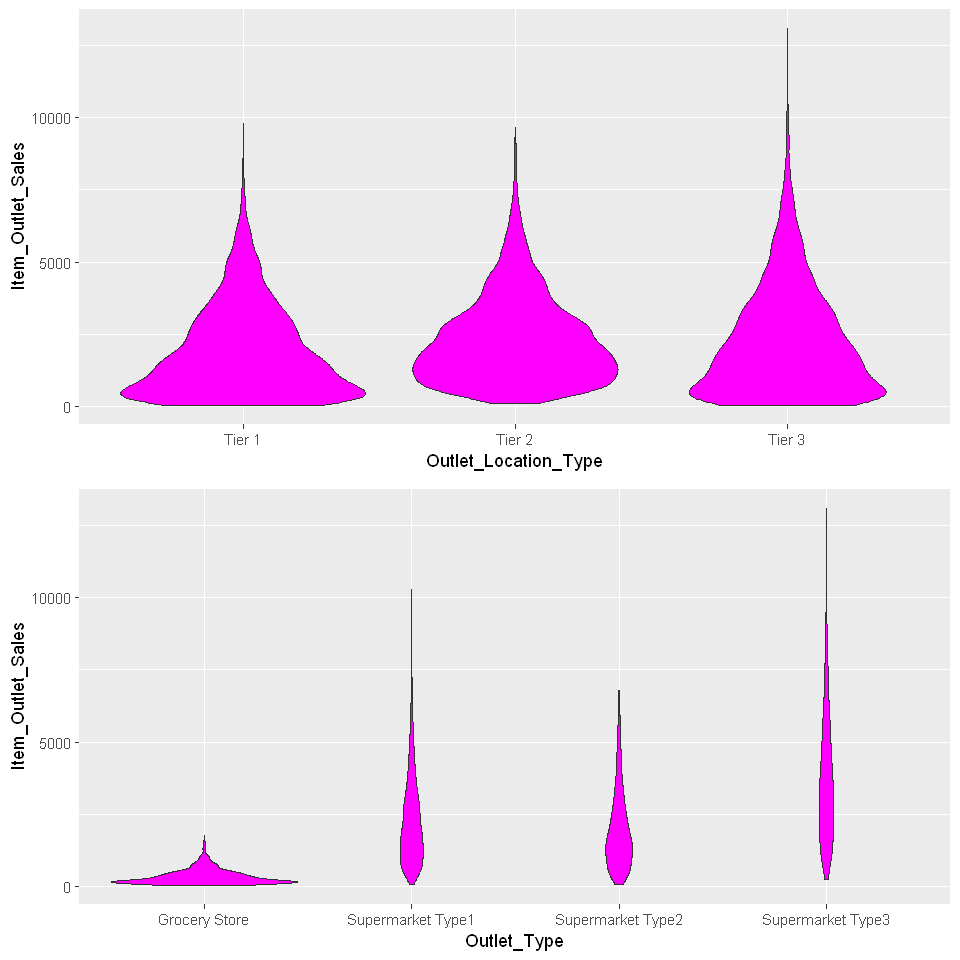

In [19]:
options(repr.plot.width = 8, repr.plot.height = 8)

# Generate a violin plot for Outlet_Location_Type and Item_Outlet_Sales
p15 = ggplot(train) + 
      geom_violin(aes(Outlet_Location_Type, Item_Outlet_Sales), fill = "magenta")

# Generate a violin plot for Outlet_Type and Item_Outlet_Sales
p16 = ggplot(train) + 
      geom_violin(aes(Outlet_Type, Item_Outlet_Sales), fill = "magenta")

# Combine both plots into one grid with one column
plot_grid(p15, p16, ncol = 1)

In [20]:
#Missing Value Treatment

#There are different methods to treat missing values based on the problem and the data. Some of the common techniques are as follows:
  
#1.Deletion of rows: In train dataset, observations having missing values in any variable are deleted. The downside of this method is the loss of information and drop in prediction power of model.

#2.Mean/Median/Mode Imputation: In case of continuous variable, missing values can be replaced with mean or median of all known values of that variable. For categorical variables, we can use mode of the given values to replace the missing values.

#3.Building Prediction Model: We can even make a predictive model to impute missing data in a variable. Here we will treat the variable having missing data as the target variable and the other variables as predictors. We will divide our data into 2 datasets-one without any missing value for that variable and the other with missing values for that variable. The former set would be used as training set to build the predictive model and it would then be applied to the latter set to predict the missing values.

#find missing values in a variable.

In [21]:
sum(is.na(combi$Item_Weight))

[1] 2439

In [22]:
#Imputing Missing Value

missing_index = which(is.na(combi$Item_Weight))
for(i in missing_index){
  
  item = combi$Item_Identifier[i]
  combi$Item_Weight[i] = mean(combi$Item_Weight[combi$Item_Identifier == item], na.rm = T)
}

In [23]:
#Cross Check

sum(is.na(combi$Item_Weight))

[1] 0

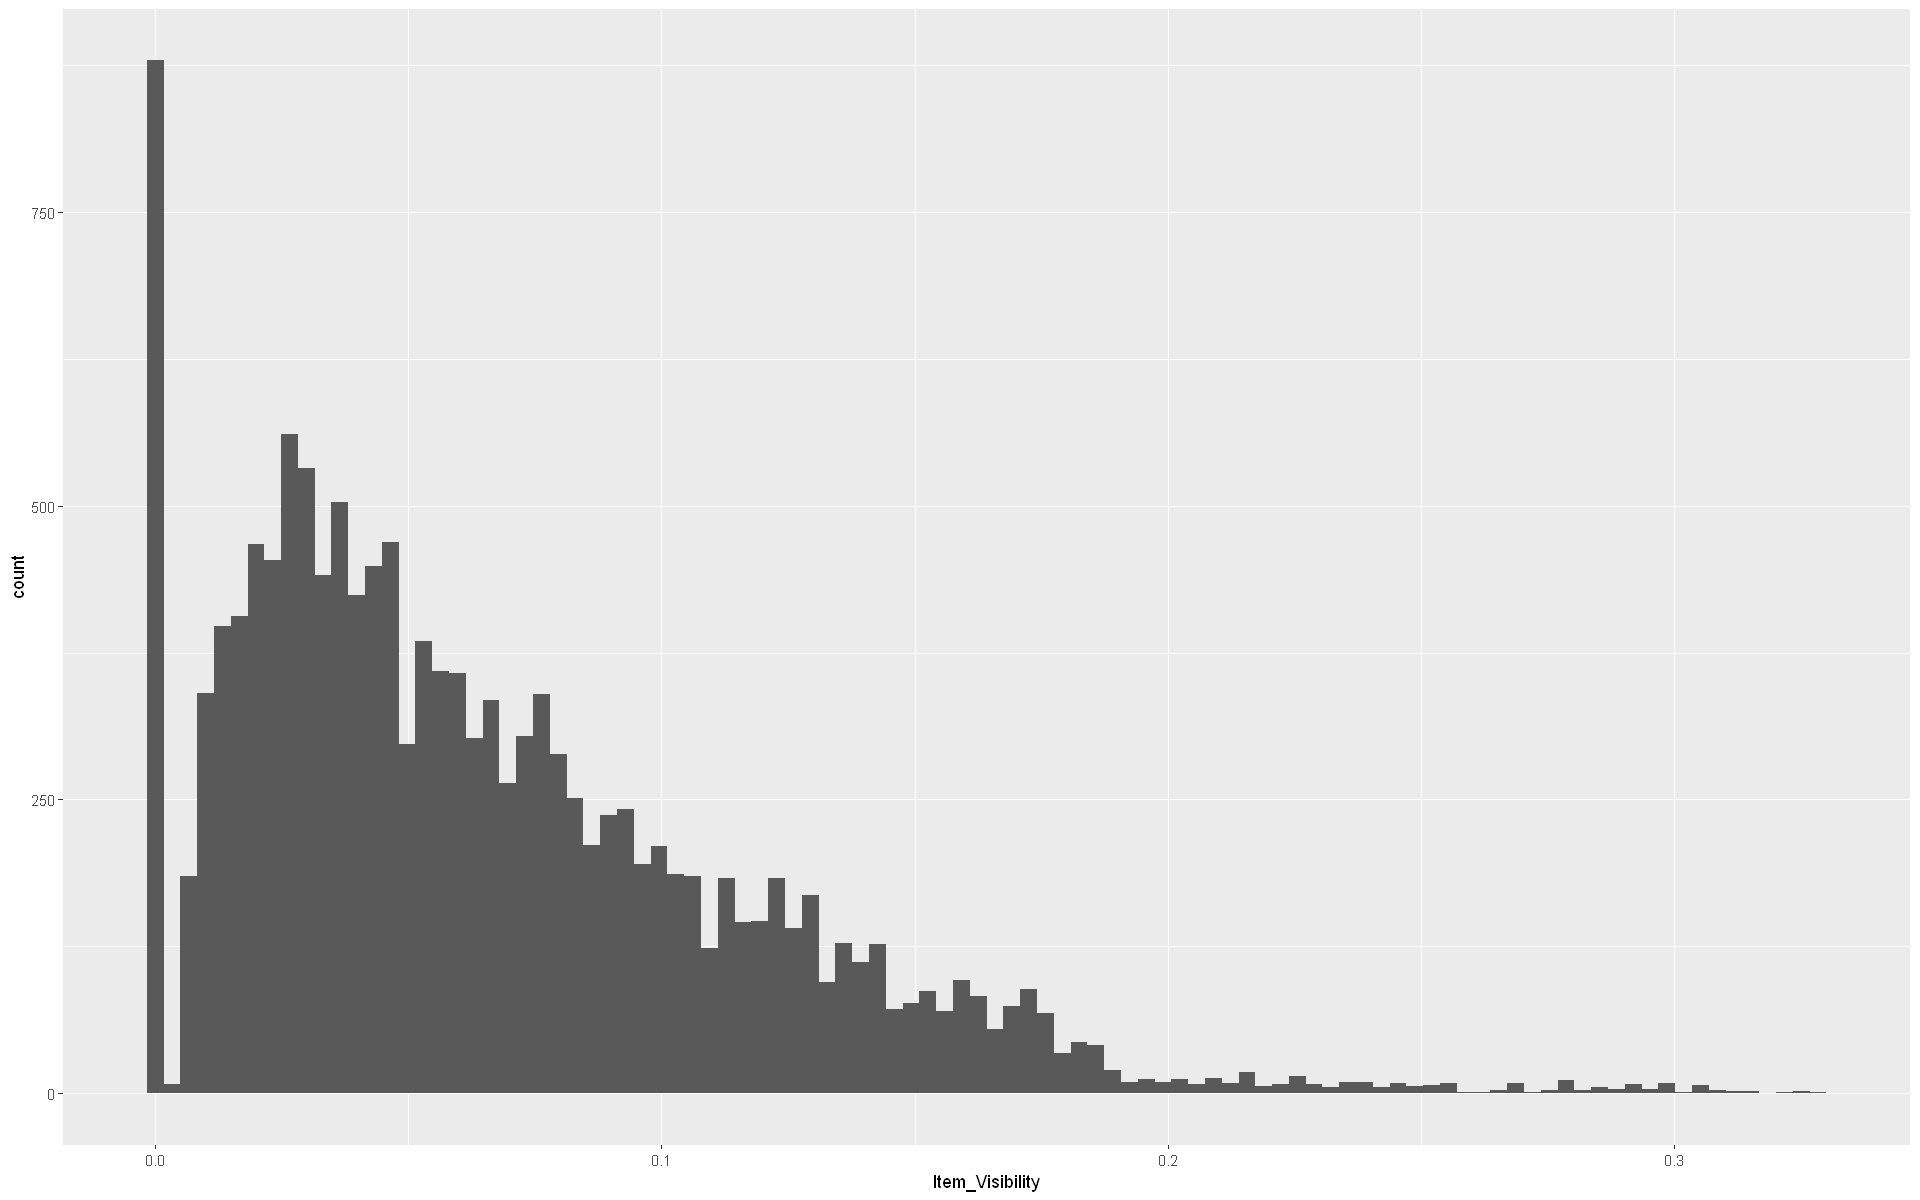

In [24]:
options(repr.plot.width = 16, repr.plot.height = 10)

#Replacing 0's in Item_Visibility variable

ggplot(combi) + geom_histogram(aes(Item_Visibility), bins = 100)

In [25]:
#replace the zeroes

zero_index = which(combi$Item_Visibility == 0)
for(i in zero_index){
  
  item = combi$Item_Identifier[i]
  combi$Item_Visibility[i] = mean(combi$Item_Visibility[combi$Item_Identifier == item], na.rm = T)
  
}
options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(combi) + geom_histogram(aes(Item_Visibility), bins = 100)

In [26]:
#Feature Engineering

#will create the following new features:
  
#1Item_Type_new: Broader categories for the variable Item_Type.
#2Item_category: Categorical variable derived from Item_Identifier.
#3Outlet_Years: Years of operation for outlets.
#4price_per_unit_wt: Item_MRP/Item_Weight
#5Item_MRP_clusters: Binned feature for Item_MRP.

In [27]:
#Item_Type variable and classify the categories into perishable and non_perishable as per our understanding and make it into a new feature.

perishable = c("Breads", "Breakfast", "Dairy", "Fruits and Vegetables", "Meat", "Seafood")
non_perishable = c("Baking Goods", "Canned", "Frozen Foods", "Hard Drinks", "Health and Hygiene", "Household", "Soft Drinks")

In [28]:
# create a new feature 'Item_Type_new'
combi[,Item_Type_new := ifelse(Item_Type %in% perishable, "perishable", ifelse(Item_Type %in% non_perishable, "non_perishable", "not_sure"))]

In [29]:
#Let's compare Item_Type with the first 2 characters of Item_Identifier, i.e., 'DR', 'FD', and 'NC'. These identifiers most probably stand for drinks, food, and non-consumable.

table(combi$Item_Type, substr(combi$Item_Identifier, 1, 2))

                       
                          DR   FD   NC
  Baking Goods             0 1086    0
  Breads                   0  416    0
  Breakfast                0  186    0
  Canned                   0 1084    0
  Dairy                  229  907    0
  Frozen Foods             0 1426    0
  Fruits and Vegetables    0 2013    0
  Hard Drinks            362    0    0
  Health and Hygiene       0    0  858
  Household                0    0 1548
  Meat                     0  736    0
  Others                   0    0  280
  Seafood                  0   89    0
  Snack Foods              0 1989    0
  Soft Drinks            726    0    0
  Starchy Foods            0  269    0

In [30]:
# Item_category Created

combi[,Item_category := substr(combi$Item_Identifier, 1, 2)]

In [31]:
#Outlet_Years (years of operation) and price_per_unit_wt (price per unit weight).

combi$Item_Fat_Content[combi$Item_category == "NC"] = "Non-Edible"

In [32]:
# years of operation for outlets
combi[,Outlet_Years := 2013 - Outlet_Establishment_Year]
combi$Outlet_Establishment_Year = as.factor(combi$Outlet_Establishment_Year)

In [33]:
# Price per unit weight
combi[,price_per_unit_wt := Item_MRP/Item_Weight]

In [34]:
#the Item_MRP vs Item_Outlet_Sales plot, we saw Item_MRP was spread across in 4 chunks. Now let's assign a label to each of these chunks and use this label as a new variable.

# creating new independent variable - Item_MRP_clusters
combi[,Item_MRP_clusters := ifelse(Item_MRP < 69, "1st", 
                                   ifelse(Item_MRP >= 69 & Item_MRP < 136, "2nd",
                                          ifelse(Item_MRP >= 136 & Item_MRP < 203, "3rd", "4th")))]

In [35]:
#Encoding Categorical Variables

#Most of the machine learning algorithms produce better result with numerical variables only. So, it is essential to treat the categorical variables present in the data

#We will use 2 techniques - Label Encoding and One Hot Encoding.

#1Label encoding simply means converting each category in a variable to a number. It is more suitable for ordinal variables - categorical variables with some order.

#2In One hot encoding, each category of a categorical variable is converted into a new binary column (1/0).

In [36]:
#Label encoding for the categorical variables

combi[,Outlet_Size_num := ifelse(Outlet_Size == "Small", 0,
                                 ifelse(Outlet_Size == "Medium", 1, 2))]
combi[,Outlet_Location_Type_num := ifelse(Outlet_Location_Type == "Tier 3", 0,
                                          ifelse(Outlet_Location_Type == "Tier 2", 1, 2))]

In [37]:
# removing categorical variables after label encoding
combi[, c("Outlet_Size", "Outlet_Location_Type") := NULL]

In [38]:
#One hot encoding for the categorical variable

ohe = dummyVars("~.", data = combi[,-c("Item_Identifier", "Outlet_Establishment_Year", "Item_Type")], fullRank = T)
ohe_df = data.table(predict(ohe, combi[,-c("Item_Identifier", "Outlet_Establishment_Year", "Item_Type")]))
combi = cbind(combi[,"Item_Identifier"], ohe_df)

In [39]:
#PreProcessing Data

#Removing Skewness

combi[,Item_Visibility := log(Item_Visibility + 1)] # log + 1 to avoid division by zero
combi[,price_per_unit_wt := log(price_per_unit_wt + 1)]

In [40]:
#Scaling numeric predictors

#Let's scale and center the numeric variables to make them have a mean of zero, standard deviation of one and scale of 0 to 1. Scaling and centering is required for linear regression models.

num_vars = which(sapply(combi, is.numeric)) # index of numeric features
num_vars_names = names(num_vars)
combi_numeric = combi[,setdiff(num_vars_names, "Item_Outlet_Sales"), with = F]
prep_num = preProcess(combi_numeric, method=c("center", "scale"))
combi_numeric_norm = predict(prep_num, combi_numeric)

combi[,setdiff(num_vars_names, "Item_Outlet_Sales") := NULL] # removing numeric independent variables
combi = cbind(combi, combi_numeric_norm)

In [41]:
#Splitting the combined data combi back to train and test set.

train = combi[1:nrow(train)]
test = combi[(nrow(train) + 1):nrow(combi)]
test[,Item_Outlet_Sales := NULL] # removing Item_Outlet_Sales as it contains only NA for test dataset

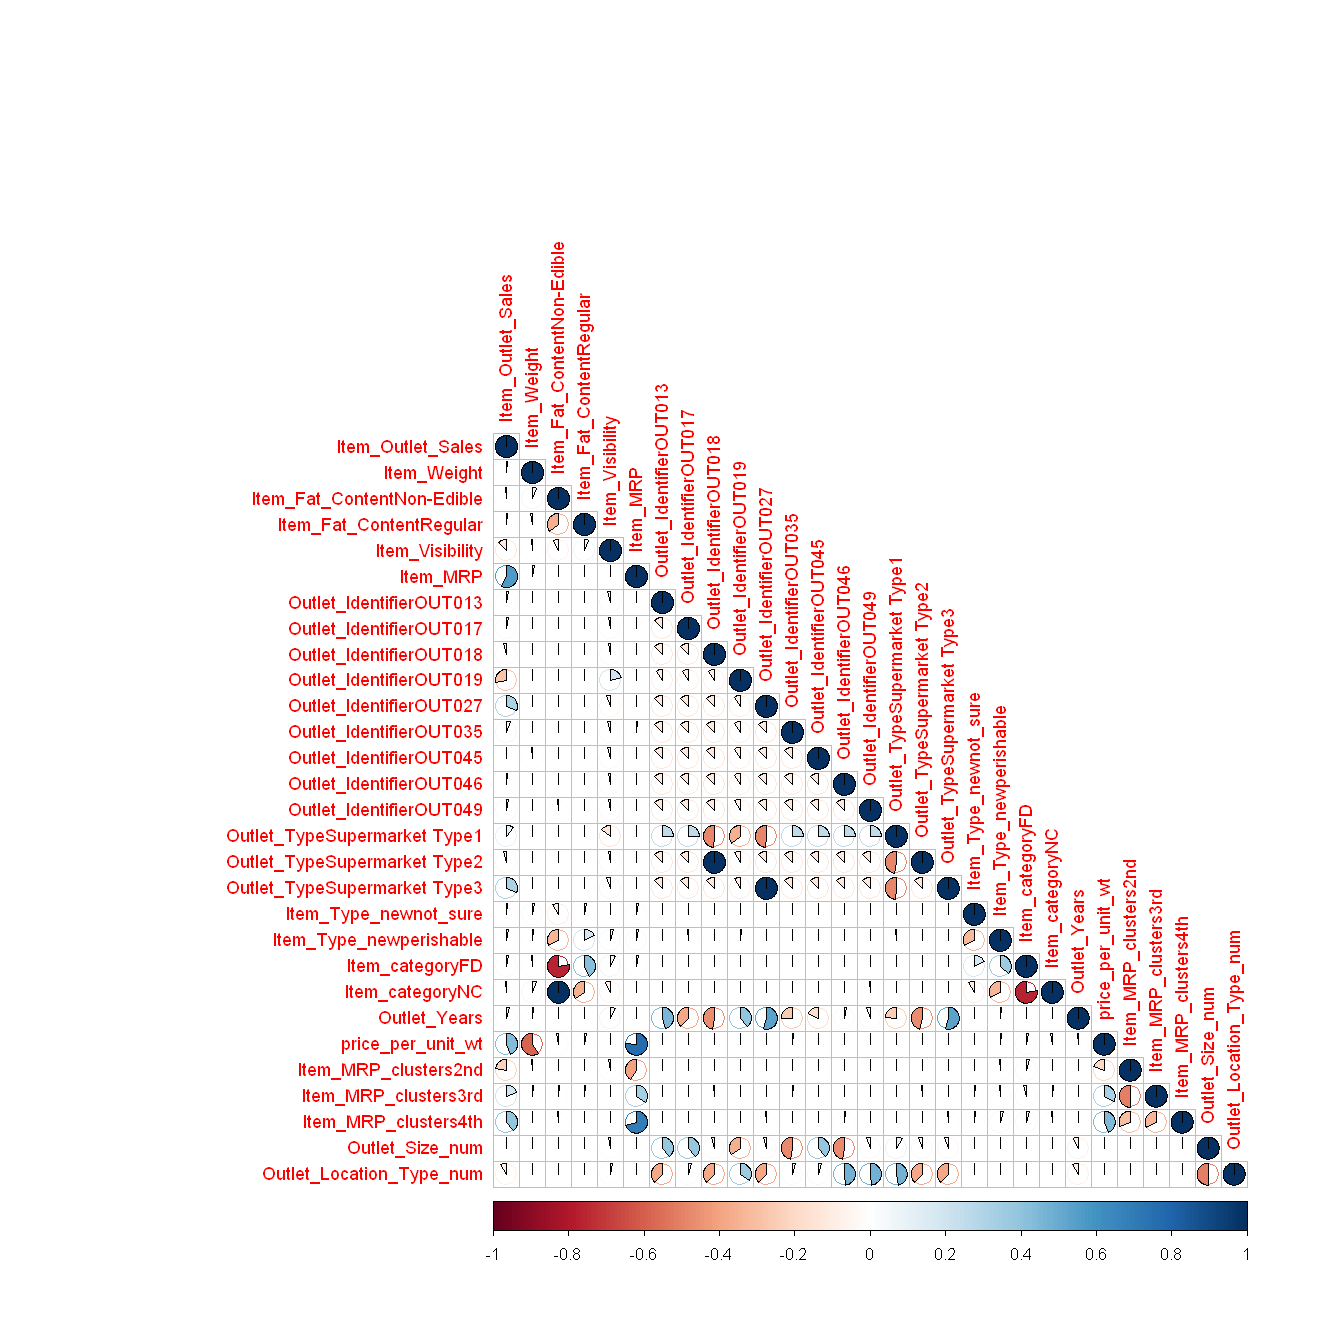

In [42]:
options(repr.plot.width = 11, repr.plot.height = 11)

#Correlated Variables

cor_train = cor(train[,-c("Item_Identifier")])
corrplot(cor_train, method = "pie", type = "lower", tl.cex = 0.9)

In [43]:
#Model Building

#Linear Regression

#Building Model

linear_reg_mod = lm(Item_Outlet_Sales ~ ., data = train[,-c("Item_Identifier")])

In [44]:
#Making Predictions on test Data

# preparing dataframe for submission and writing it in a csv file
submission$Item_Outlet_Sales = predict(linear_reg_mod, test[,-c("Item_Identifier")])
write.csv(submission, "Linear_Reg_submit.csv", row.names = F)

In [45]:
#Lasso Regression

set.seed(1235)
my_control = trainControl(method="cv", number=5)
Grid = expand.grid(alpha = 1, lambda = seq(0.001,0.1,by = 0.0002))

lasso_linear_reg_mod = train(x = train[, -c("Item_Identifier", "Item_Outlet_Sales")], y = train$Item_Outlet_Sales,
                             method='glmnet', trControl= my_control, tuneGrid = Grid)

In [46]:
# mean validation score
x1 = mean(lasso_linear_reg_mod$resample$RMSE)
x1

[1] 1129.527

In [47]:
#Ridge Regression

set.seed(1236)
my_control = trainControl(method="cv", number=5)
Grid = expand.grid(alpha = 0, lambda = seq(0.001,0.1,by = 0.0002))

ridge_linear_reg_mod = train(x = train[, -c("Item_Identifier", "Item_Outlet_Sales")], y = train$Item_Outlet_Sales,
                             method='glmnet', trControl= my_control, tuneGrid = Grid)

In [48]:
# mean validation score
x2 = mean(ridge_linear_reg_mod$resample$RMSE)
x2

[1] 1134.585

In [49]:
#RandomForest 

set.seed(1237)
my_control = trainControl(method="cv", number=5)

tgrid = expand.grid(
  .mtry = c(3:10),
  .splitrule = "variance",
  .min.node.size = c(10,15,20)
)

rf_mod = train(x = train[, -c("Item_Identifier", "Item_Outlet_Sales")], 
               y = train$Item_Outlet_Sales,
               method='ranger', 
               trControl= my_control, 
               tuneGrid = tgrid,
               num.trees = 400,
               importance = "permutation")

In [50]:
# mean validation score
x3 = mean(rf_mod$resample$RMSE)
x3

[1] 1086.932

In [51]:
options(repr.plot.width = 11, repr.plot.height = 11)

#Best Model Parameters

plot(rf_mod)

In [52]:
options(repr.plot.width = 11, repr.plot.height = 11)

#Variable Importance

plot(varImp(rf_mod))

In [53]:
#XGBoost

param_list = list(
  
  objective = "reg:linear",
  eta=0.01,
  gamma = 1,
  max_depth=6,
  subsample=0.8,
  colsample_bytree=0.5
)
dtrain = xgb.DMatrix(data = as.matrix(train[,-c("Item_Identifier", "Item_Outlet_Sales")]), label= train$Item_Outlet_Sales)
dtest = xgb.DMatrix(data = as.matrix(test[,-c("Item_Identifier")]))

In [54]:
#Variable Importance

set.seed(112)
xgbcv = xgb.cv(params = param_list, 
               data = dtrain, 
               nrounds = 1000, 
               nfold = 5, 
               print_every_n = 10, 
               early_stopping_rounds = 30, 
               maximize = F)

x4 = tail(xgbcv$evaluation_log, 1)

[20:34:26] WARNING: src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:26] WARNING: src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:26] WARNING: src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:26] WARNING: src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:26] WARNING: src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:2746.426431+11.012787	test-rmse:2746.124780+46.485937 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 30 rounds.

[11]	train-rmse:2535.954301+13.955221	test-rmse:2536.542359+43.075406 
[21]	train-rmse:2347.531684+10.009412	test-rmse:2350.005624+45.439761 
[31]	train-rmse:2180.274438+10.473806	test-rmse:2184.860913+43.495194 
[41]	

In [55]:
#Model Training

xgb_model = xgb.train(data = dtrain, params = param_list, nrounds = 426)

[20:35:19] WARNING: src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [56]:
options(repr.plot.width = 11, repr.plot.height = 11)

#Variable Importance

var_imp = xgb.importance(feature_names = setdiff(names(train), c("Item_Identifier", "Item_Outlet_Sales")), 
                         model = xgb_model)
xgb.plot.importance(var_imp)

In [58]:
model_data <- data.frame(
  Model_Name = c("Linear Regression", "Ridge Regression", "RandomForest", "XGBoost"),
  Validation_Score = c(x1, x2, x3, x4$test_rmse_mean)   # replace with your actual CV scores
)
model_data

Model_Name        Validation_Score
1 Linear Regression 1129.527        
2 Ridge Regression  1134.585        
3 RandomForest      1086.932        
4 XGBoost           1090.534

In [63]:
options(repr.plot.width = 8, repr.plot.height = 7)

# Sort the data frame by Validation_Score in descending order
model_data <- model_data[order(-model_data$Validation_Score), ]

# Sort the data frame by Validation_Score in descending order
model_data <- model_data[order(-model_data$Validation_Score), ]

# Create the bar graph
ggplot(model_data, aes(x = reorder(Model_Name, -Validation_Score), y = Validation_Score)) +
  geom_bar(stat = "identity", fill = "orange", width = 0.5) +  # width argument to control the spacing
  geom_text(aes(label = round(Validation_Score, 2)), vjust = -0.3) +  # Add validation score on the bars
  labs(title = "Validation Score Vs Prediction Model",
       x = "Models",
       y = "Validation Score") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))  # Center align the title